          1       2       3       4       5       6       7
0    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
10   0.0369  0.0006  0.0000  0.0000  0.0000  0.0000  0.0000
20   0.0724  0.0026  0.0001  0.0000  0.0000  0.0000  0.0000
30   0.1066  0.0057  0.0002  0.0000  0.0000  0.0000  0.0000
40   0.1395  0.0100  0.0005  0.0000  0.0000  0.0000  0.0000
50   0.1713  0.0153  0.0009  0.0000  0.0000  0.0000  0.0000
60   0.2018  0.0216  0.0015  0.0001  0.0000  0.0000  0.0000
70   0.2313  0.0287  0.0024  0.0001  0.0000  0.0000  0.0000
80   0.6284  0.1463  0.0196  0.0018  0.0001  0.0000  0.0000
90   0.6421  0.1643  0.0246  0.0025  0.0002  0.0000  0.0000
100  0.6553  0.1822  0.0300  0.0034  0.0003  0.0000  0.0000
110  0.9768  0.6091  0.1490  0.0181  0.0014  0.0001  0.0000
120  1.0000  0.6803  0.2173  0.0423  0.0058  0.0006  0.0001
130  1.0000  0.6920  0.2346  0.0490  0.0072  0.0008  0.0001
140  1.0000  0.7034  0.2516  0.0561  0.0089  0.0011  0.0001
150  1.0000  0.7143  0.2685  0.0636  0.0

<AxesSubplot:>

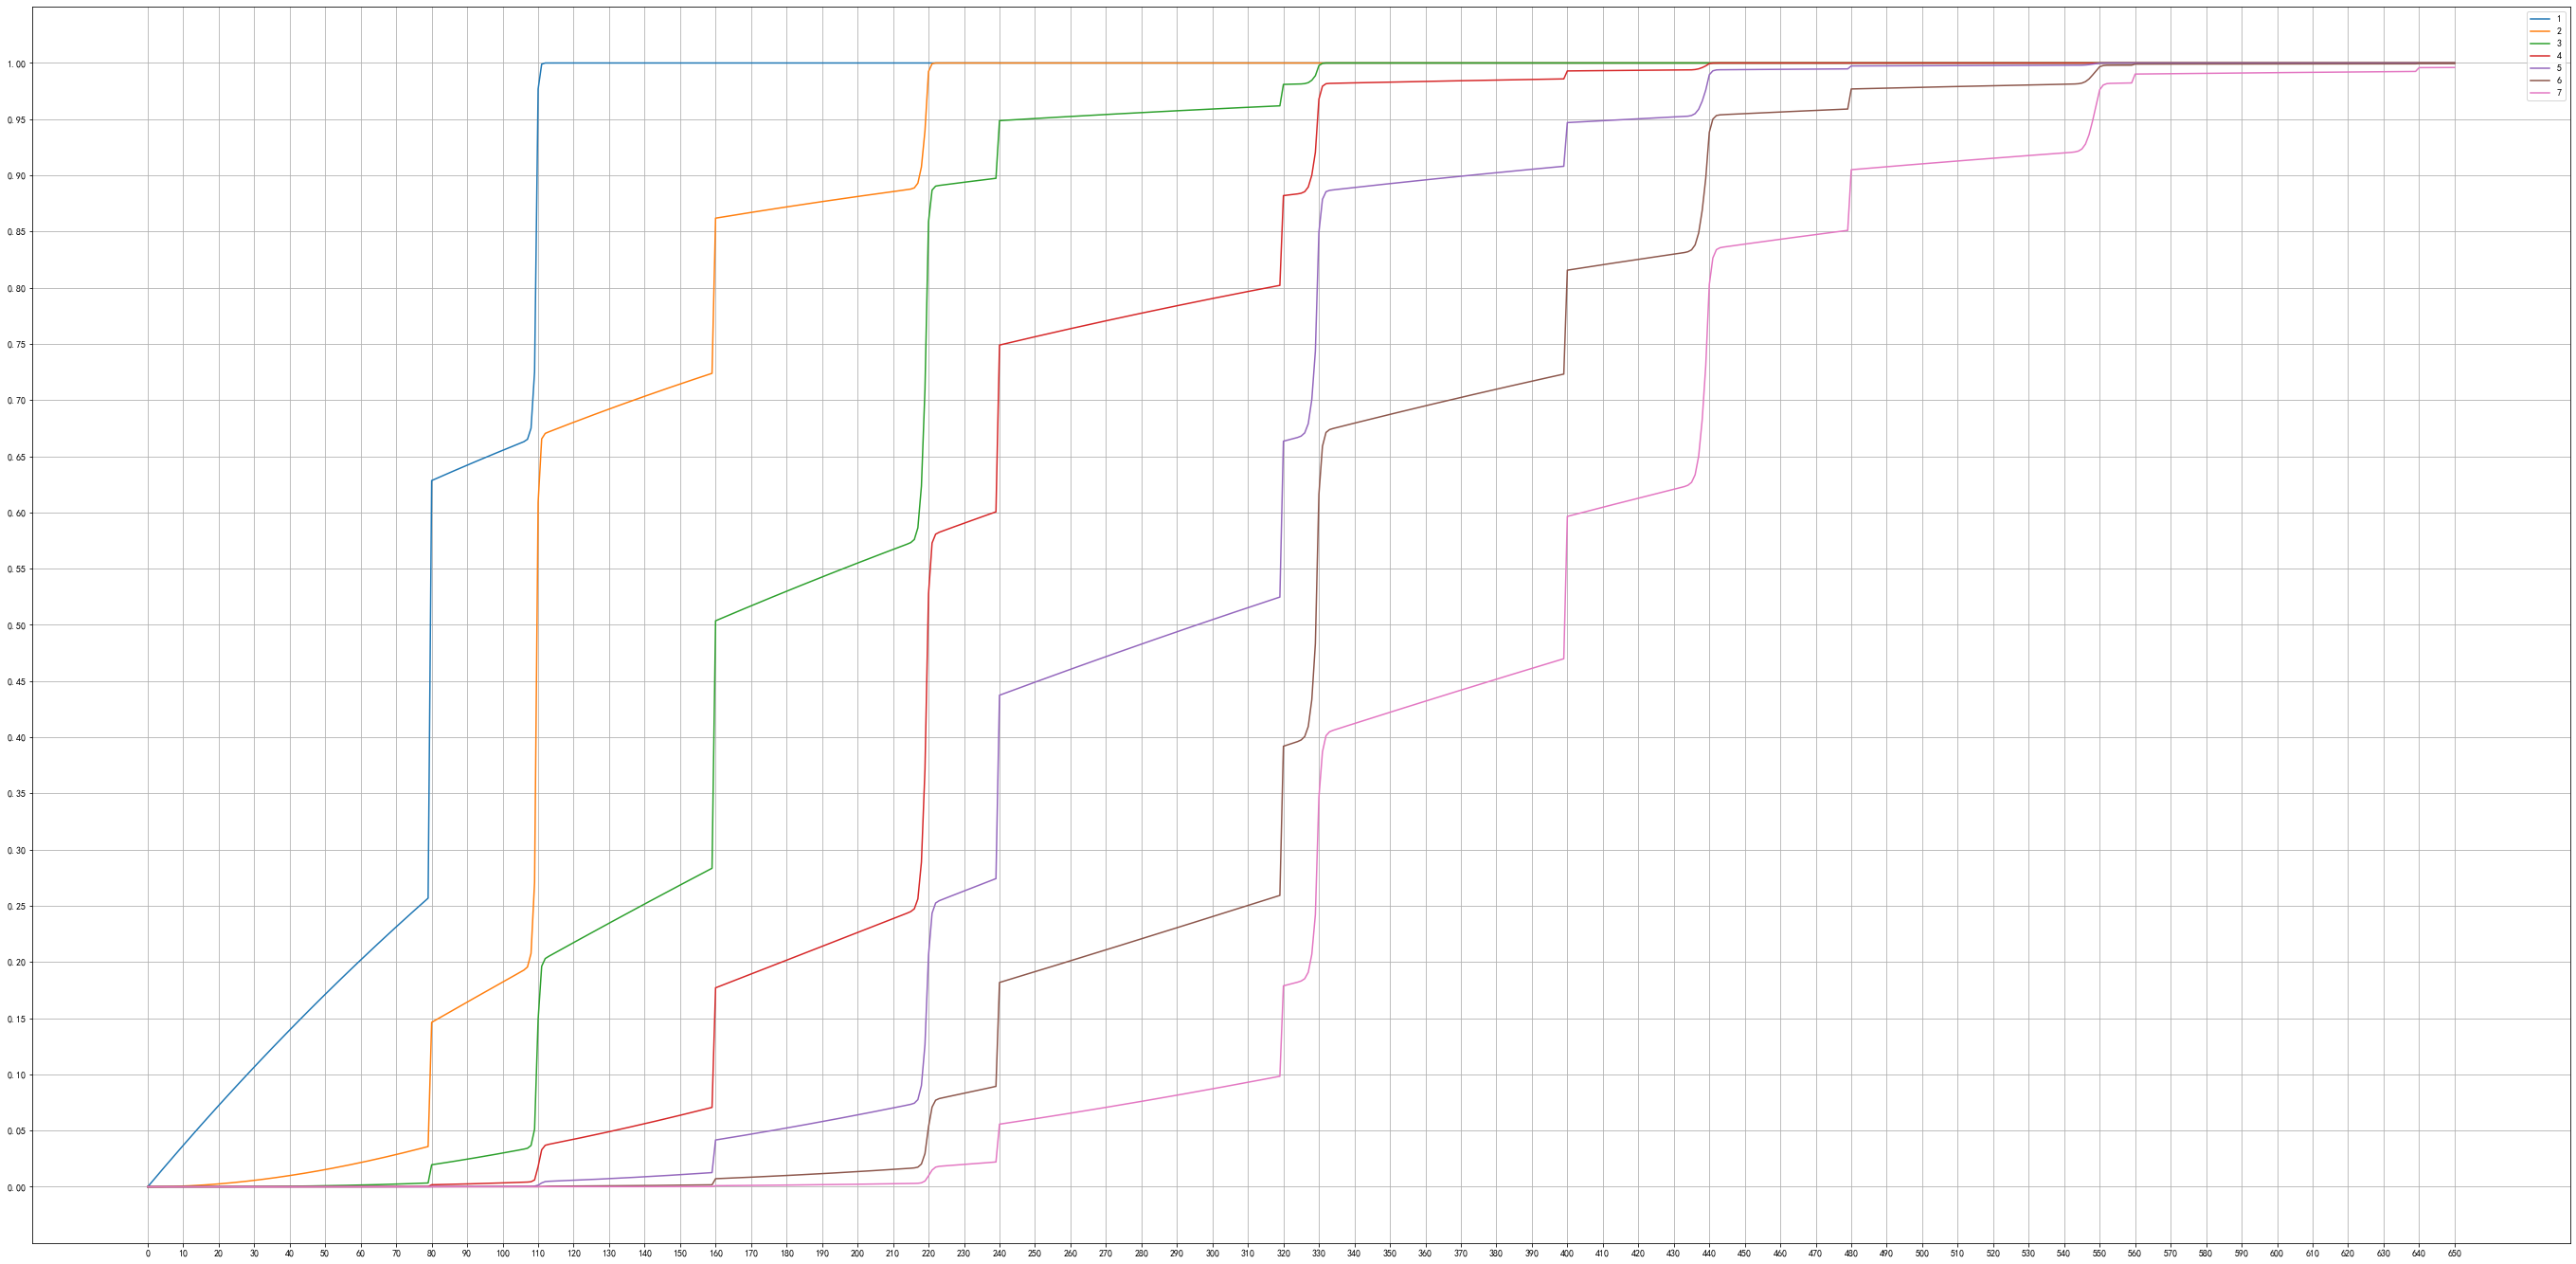

In [1]:
#jupyter notebook的基本环境设置
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

import numpy
import pandas
pandas.set_option("display.max_rows",1000)

import matplotlib
matplotlib.rcParams["font.sans-serif"]=["SimHei"]
matplotlib.rcParams["axes.unicode_minus"]=False

#幻塔官方公布的抽卡概率数值
SSR_PROBABILITY_BASIC=0.0075
SR_PROBABILITY_BASIC=0.01
SSR_PROBABILITY_CRITICAL=0.5
SSR_INSURANCE_LIMIT=80
SR_INSURANCE_LIMIT=10
SSR_PRICE_GOLD_CAST=120
SSR_MAX_COUNT=7

#开始抽卡前的状态配置，请注意根据自身情况修改
MAX_STEPS=650#最多抽这么多次
SSR_INSURANCE=0#当前SSR小保底计数
SR_INSURANCE=0#当前SR保底计数
GOLD_CAST=0#当前已有回火铸金数

def AddOrUpdate(state,key,value):
    if key in state:
        state[key]+=value
    else:
        state[key]=value
#处理铸金到SSR取得数的转换，以及设置SSR取得数封顶以避免状态空间无限扩展
def ProcessState(ssr_count,ssr_insurance,sr_insurance,gold_cast):
    if gold_cast>=SSR_PRICE_GOLD_CAST:
        ssr_count+=gold_cast//SSR_PRICE_GOLD_CAST
        gold_cast%=SSR_PRICE_GOLD_CAST
    if ssr_count>=SSR_MAX_COUNT:#都已经抽满了还算个毛线
        return (SSR_MAX_COUNT,0,0,0)
    return ssr_count,ssr_insurance,sr_insurance,gold_cast
#当前状态概率分布为state，计算下一抽后的概率分布
def Transfer(state):
    result={}
    for (ssr_count,ssr_insurance,sr_insurance,gold_cast),probability in state.items():
        if ssr_count>=SSR_MAX_COUNT:
            AddOrUpdate(result,(SSR_MAX_COUNT,0,0,0),probability)
            continue
        ssr_insurance+=1
        sr_insurance+=1
        #SSR小保底，只有两种可能
        if ssr_insurance>=SSR_INSURANCE_LIMIT:
            AddOrUpdate(result,ProcessState(ssr_count+1,0,0,gold_cast+1),probability*SSR_PROBABILITY_CRITICAL)
            AddOrUpdate(result,ProcessState(ssr_count,0,0,gold_cast+1),probability*(1-SSR_PROBABILITY_CRITICAL))
            continue
        #非保底出SSR的结算比SR保底优先
        AddOrUpdate(result,ProcessState(ssr_count+1,ssr_insurance,0,gold_cast+1),probability*SSR_PROBABILITY_BASIC*SSR_PROBABILITY_CRITICAL)
        AddOrUpdate(result,ProcessState(ssr_count,ssr_insurance,0,gold_cast+1),probability*SSR_PROBABILITY_BASIC*(1-SSR_PROBABILITY_CRITICAL))
        #SR保底且未命中SSR
        if sr_insurance>=SR_INSURANCE_LIMIT:
            AddOrUpdate(result,ProcessState(ssr_count,ssr_insurance,0,gold_cast+2),probability*(1-SSR_PROBABILITY_BASIC))
            continue
        #非保底且未命中SSR
        AddOrUpdate(result,ProcessState(ssr_count,ssr_insurance,0,gold_cast+2),probability*(1-SSR_PROBABILITY_BASIC)*SR_PROBABILITY_BASIC)
        AddOrUpdate(result,ProcessState(ssr_count,ssr_insurance,sr_insurance,gold_cast+1),probability*(1-SSR_PROBABILITY_BASIC)*(1-SR_PROBABILITY_BASIC))
    return result
#简化概率分布，只关心SSR取得数
def GetDistribute(state):
    result=[0]*(SSR_MAX_COUNT)
    for (ssr_count,_,__,___),probability in state.items():
        for i in range(ssr_count):
            result[i]+=probability
    return result
#执行概率计算
def CalculateSteps(max_step,ssr_insurance=0,sr_insurance=0,gold_cast=0):
    results=[{(0,ssr_insurance,sr_insurance,gold_cast):1}]
    for _ in range(max_step):
        results.append(Transfer(results[-1]))
        results[-2]=GetDistribute(results[-2])
    for i,j in results[-1].items():
        if i[0]==0:
            print(i,j)
    results[-1]=GetDistribute(results[-1])
    return pandas.DataFrame(results,columns=range(1,SSR_MAX_COUNT+1))

#执行概率计算并输出
final_result=CalculateSteps(MAX_STEPS,SSR_INSURANCE,SR_INSURANCE,GOLD_CAST)
print(final_result.iloc[range(0,MAX_STEPS+1,10)].round(4))
final_result.plot(figsize=(48,24),grid=True,xticks=range(0,MAX_STEPS+1,10),yticks=[i/20 for i in range(21)])